In [3]:
# -*- coding: utf-8 -*-
"""
Created on Fri Nov 19 23:29:34 2021

@author: cmbbd
"""

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
import numpy as np
import re
import os 
import json

stop = set(stopwords.words("english"))
stop.add('data')
stop.add('result')
stop.add('results')
stop.add('model')
stop.add('method')
stop.add('result')
stop.add('use')
stop.add('approach')
stop.add('algorithm')
stop.add('problem')
stop.add('propos')
stop.add('paper')

article1 = pd.read_csv('article_subject.csv')

f = open('subjects.csv','r',encoding='utf-8')
d = f.read()
d = d.replace("\'", '\"')
d = d.replace("\\", '')
liste = d.split("}")
CORRESPONDANCE_json = []
CORRESPONDANCE = []
list_json_title = []
list_json_subjects = []

#Data extraction
for i in range(len(liste[:-1])):
    try:
        q = liste[i] + "}"
        q = q[1:]
        q = json.loads(q)
        list_json_subjects.append(q['subjects'])
        list_json_title.append(q['title'])
    except :
        print('error')
TITLE = article1['0'].to_numpy()        
for i in range(len(list_json_title)):
    if (list_json_title[i] in TITLE):
        CORRESPONDANCE_json.append(i)
        CORRESPONDANCE.append(list(TITLE).index(list_json_title[i]))
#Data cleaning 
article = article1.to_numpy()[CORRESPONDANCE]
article = pd.DataFrame(article)        
article['subjects'] = np.array(list_json_subjects)[CORRESPONDANCE_json]       
article = article.dropna(axis=0)

article.columns = ['0','title','description','subject','publication','subjects']
article = article.drop(['0','subject'],axis=1)


import string


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cmbbd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error


<ipython-input-3-357b21db512e>:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  article['subjects'] = np.array(list_json_subjects)[CORRESPONDANCE_json]


In [33]:


def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

def remove_nb(text):
  
  nb = re.compile(r"/d+")
  return nb.sub(r"", text)
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]

    return " ".join(text)

article["description"] = article.description.map(lambda x: remove_punct(x))
article["description"] = article.description.map(lambda x: remove_nb(x))
article["description"] = article["description"].map(remove_stopwords)


def keywords(description,k):
    
        KEY = []
        for i in range(len(description)):
            try:
                cur = description[i]
                Vect = TfidfVectorizer()
                TF = Vect.fit([cur])
                L = Vect.transform([cur])
                star_list = list(np.array(TF.get_feature_names())[L.toarray().argsort()[0]][-k:])
                KEY.append(" ".join(item for item in star_list))
            except:
                print(i)
                print('an error occurs')
               
        return(KEY)
    
    

def tokenize_and_stem(text):
    from nltk.stem.snowball import SnowballStemmer
    stemmer = SnowballStemmer("english")
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token) :
            
            filtered_tokens.append(token)
    stems1 = [stemmer.stem(t) for t in filtered_tokens]
    stems = []
    for i in stems1:
        if i not in stop:
            stems.append(i)
            
    return stems
def distance(article):

    from sklearn.metrics.pairwise import cosine_similarity
    
    VECT= TfidfVectorizer(min_df=0.01,use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))
    TF = VECT.fit_transform(article['description'])
    dist = 1 - cosine_similarity(TF)
    return([dist,TF,VECT])

def euclidian(tf):
    from sklearn.metrics.pairwise import manhattan_distances
    return( 1 - cosine_similarity(tf))

def neighborhood(dist,thres):
    THRES = (thres>dist)
    VOIS = []
    ITEMS = np.array([i for i in range(len(dist))])
    for i in range(len(np.transpose(THRES))):
        VOIS.append(ITEMS[THRES[:,i]])
    return(VOIS)
    

def cluster(tf,k):
    from sklearn.cluster import AffinityPropagation
    from sklearn.cluster import KMeans
    from sklearn.cluster import OPTICS
    from sklearn.cluster import AgglomerativeClustering

    num_clusters = k
    
    km = KMeans(n_clusters=k)
    km.fit(tf)
    clusters = km.labels_.tolist()
    return [clusters,km]
    
    
def key_cluster(DESCRIPTION,clusters,nb_clusters,nb_keywords):
    CLUS = [[] for i in range(nb_clusters)]
    
    for i in range(len(DESCRIPTION)):
        CLUS[clusters[i]].append(DESCRIPTION[i])
        
    KEY = [keywords([str(CLUS[i])],nb_keywords) for i in range(nb_clusters)]
    return([CLUS,KEY])

def publi_clusters(PUBLICATION,clusters,nb_clusters):
    PUBLI_cluster = [[] for i in range(nb_clusters)]
    for i in range(len(PUBLICATION)):
        PUBLI_cluster[clusters[i]].append(PUBLICATION[i])
    return(PUBLI_cluster)
        
def hist_publi(PUBLI_cluster):
    from collections import Counter
    for i in range(len(PUBLI_cluster)):
        count = Counter(np.array(PUBLI_cluster[i]))
        df = pd.DataFrame.from_dict(count, orient='index')
        df.plot(kind='bar',title=str(i),figsize=(12,10))
        


def cluster_VOIS(VOIS):
    CLUSTER = [[]]
    for i in range(len(VOIS)):
        in_ = 0
        j=0
        while j<len(CLUSTER) and in_==0 :
            if i in CLUSTER[j]:
                in_=1
            else:
                j+=1
        if  in_== 0:
            CLUSTER.append([])
            for k in VOIS[i]:
                CLUSTER[-1].append(k)
        else:
            for k in VOIS[i]:
                if k not in CLUSTER[j]:
                    CLUSTER[j].append(k)
    return(CLUSTER)

def closest_neighbor(dist):
    CN = [[] for i in range(len(dist))]
    for i in range(len(dist)):
        CN[i].append([np.argmin(dist[i]),np.min(dist[i])])
    return(CN)

def k_closest_neighbor(dist,k):
    CN = [[] for i in range(len(dist))]
    for i in range(len(dist)):
        l = zip(np.argsort(dist[i],axis=0)[:k],np.sort(dist[i],axis=0)[:k])
        for d,ind in l:
            CN[i].append([d,ind])
    return(CN)      
            
def get_neighborhing(clusters,VOIS,j):
    label = clusters[j]
    vois = VOIS[j]
    k=0
    for i in vois:
        if clusters[int(i)]==label:
            k+=1
    return(k/len(vois))
    


In [27]:
        
        
nb_clusters = 32
article_train,article_test = train_test_split(article,test_size=0.9,random_state=5)

[dist,tf,VECT] = distance(article_train)
VOIS = k_closest_neighbor(dist,3)
#[clusters,km] = cluster(dist,nb_clusters) 
article_train["stem"] = article_train.description.map(tokenize_and_stem)       
#[CLUS,KEY] = key_cluster(article_train.stem.to_numpy(),clusters,nb_clusters,5)



<ipython-input-27-9cfc230c3dbe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_train["stem"] = article_train.description.map(tokenize_and_stem)


In [140]:
from sklearn.metrics import silhouette_score

for nb_clusters in range(75,95,10):
    SCORE.append([])
    [clusters,km] = cluster(dist,nb_clusters)
    SCORE[-1].append(silhouette_score(dist,clusters))
    for i in range(2,16,2):
        VOIS = np.array(k_closest_neighbor(dist,i))
        L = []
        for r in range(len(clusters)):
            l = get_neighborhing(clusters,VOIS[:,1:,0],r)
            L.append(l)
        SCORE[-1].append(np.mean(L))





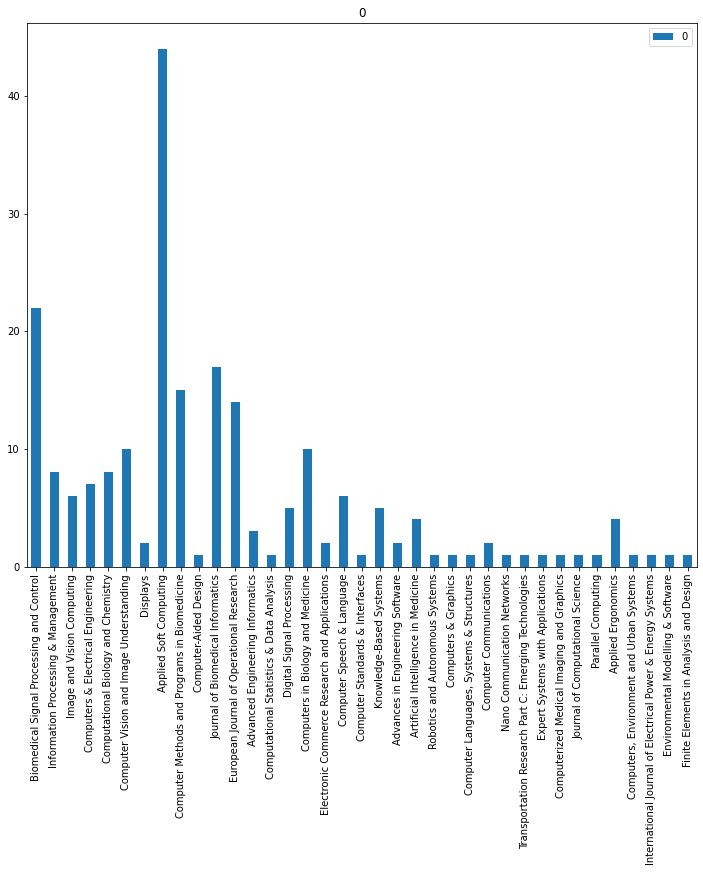

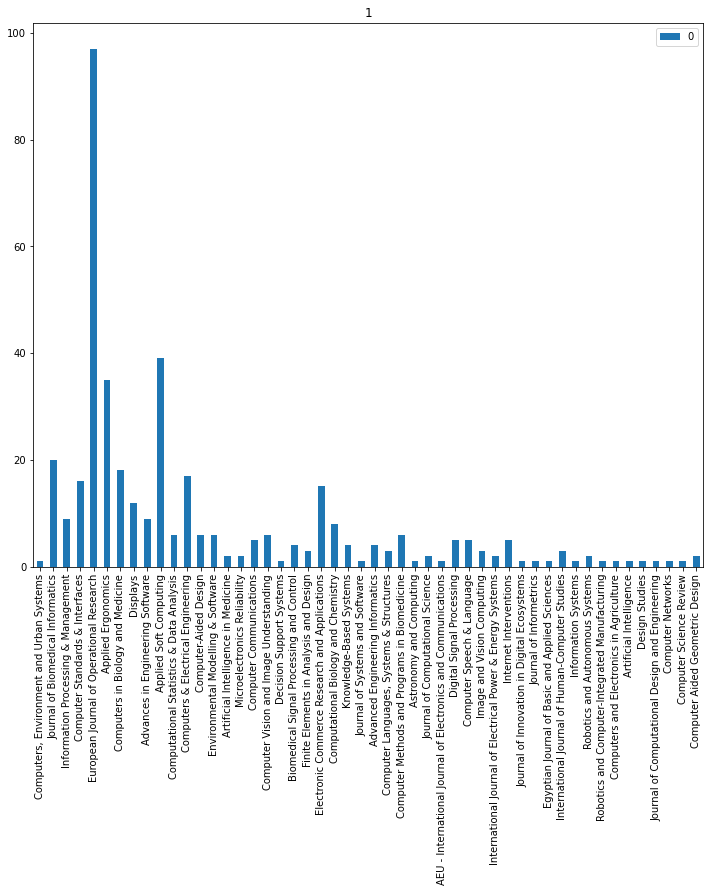

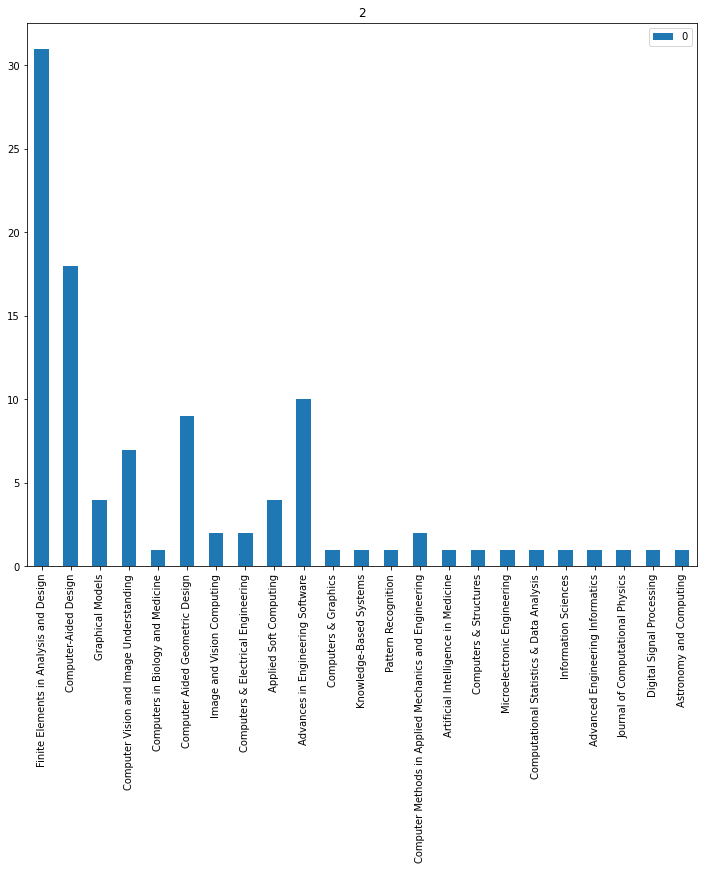

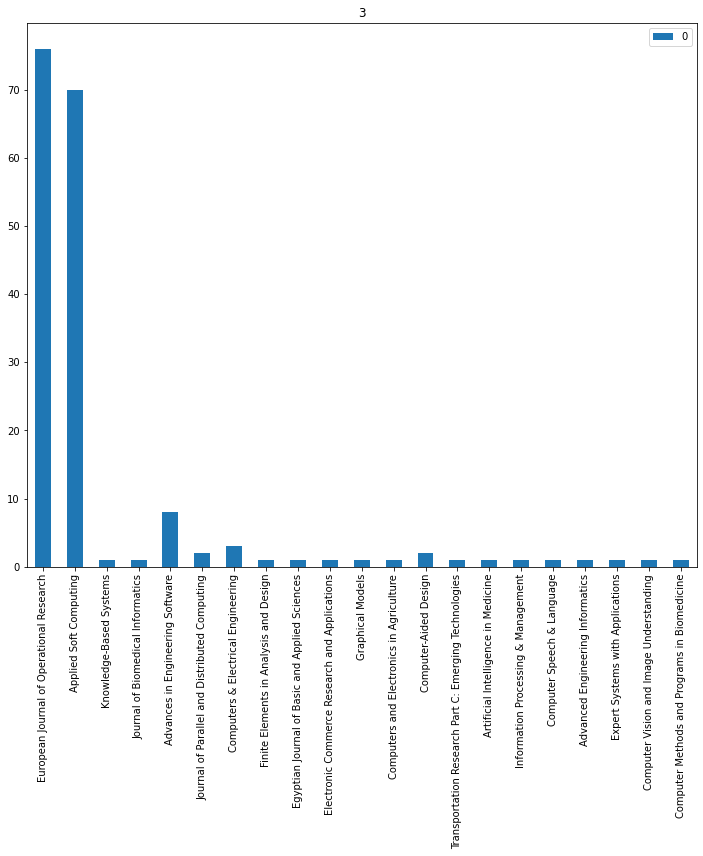

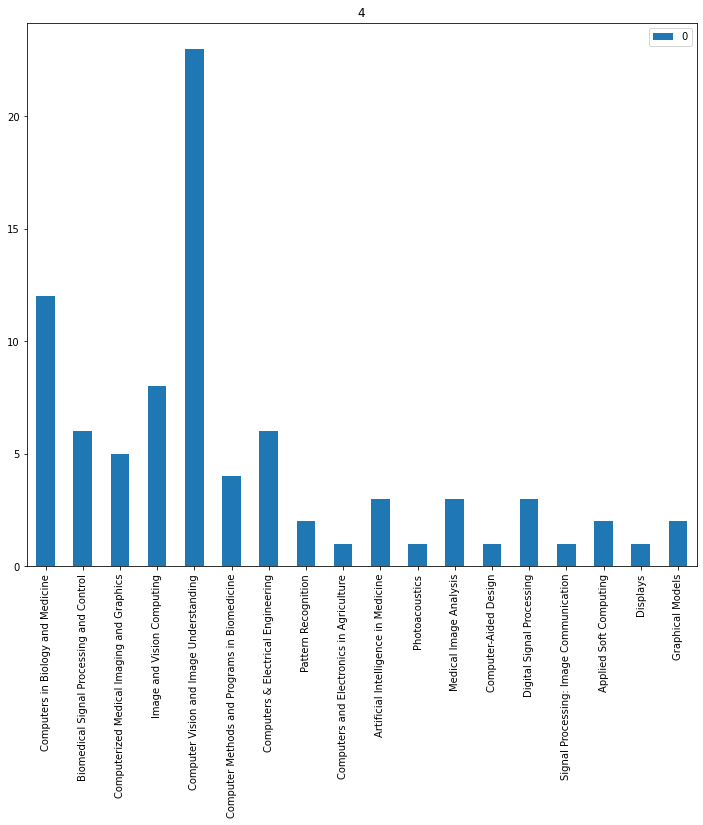

In [34]:
nb_clusters = 5
[clusters,km] = cluster(dist,nb_clusters)
PUBLI_cluster = publi_clusters(article_train.publication.to_numpy(),clusters,5)
hist_publi(PUBLI_cluster)  

In [142]:
SCORE.remove(SCORE[-2])


In [143]:
df = pd.DataFrame(SCORE)
df.columns = ['silhouette_score','n_score(p=2)','n_score(p=4)','n_score(p=6)','n_score(p=8)','n_score(p=10)','n_score(p=12)','n_score(p=14)']
df.index = ['n_clusters = '+str(i) for i in range(5,95,10)]
df = df.round(3)
df.to_csv('AG_6000.csv')


In [ ]:
#PUBLI_cluster = publi_clusters(article_train.publication.to_numpy(),clusters,nb_clusters)
#hist_publi(PUBLI_cluster)   

In [147]:
SCORE]



[]

In [154]:
    TITLE = article_train.title.to_numpy()
    TITLE_cluster = [[] for i in range(132)]
    for i in range(len(TITLE)):
        TITLE_cluster[clusters[i]].append(TITLE[i])

In [80]:

from sklearn.metrics.pairwise import cosine_similarity
tf2 = VECT.transform(article_test['description'])
d2 = np.array(1-cosine_similarity(tf,tf2)) 
prediction = km.predict_classes(np.transpose(d2))
VOIS2 =neighborhood(d2,0.65)
article_test['neigh'] = VOIS2 

AttributeError: 'HDBSCAN' object has no attribute 'predict_classes'

In [ ]:
article_train['title'].to_numpy()[6429]

'Group versus Internet-based cognitive-behavioral therapy for procrastination: Study protocol for a randomized controlled trial '

In [ ]:
article_train['title'].to_numpy()[6308]

'For whom are internet-based occupational mental health interventions effective? Moderators of internet-based problem-solving training outcome '

In [ ]:
pip install --upgrade 


Note: you may need to restart the kernel to use updated packages.


ERROR: You must give at least one requirement to install (see "pip help install")


In [153]:
#Relevance of the clusters

score = silhouette_score(dist,clusters)
score

0.06284416037402481

In [ ]:
#Keywords within all the clusters
[CLUS,KEY] = f.key_cluster(f.article_train.stem.to_numpy(),f.clusters,f.nb_clusters,10)
print(KEY[24])
print(KEY[65])
KEY[55]

['diseas identifi studi base network select analysi cancer express gene']
['planar present polynomi geometr space control point surfac ration curv']


['evalu studi health develop research inform patient system medic clinic']

In [ ]:
import numpy as np
CN = f.closest_neighbor(np.transpose(f.d2))
f.article_test['neigh'] = CN

<ipython-input-2-23281b50d3fe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.article_test['neigh'] = CN


In [ ]:
CN = k_closest_neighbor(np.transpose(f.d2),4)

In [ ]:
import numpy as np
CN = np.array(CN)

In [ ]:
def recommendation(CN_i):
    import pandas as pd
    RECO = []
    for i in range(len(CN_i)):
        RECO.append(f.article_train.to_numpy()[int(CN_i[i][0])])
    return(pd.DataFrame(RECO))
#f.article_train.to_numpy()[int(CN[1][2][0])]
    
    
    

In [ ]:
f.article_test.to_numpy()[1789]

array(['Cryptic tRNAs in chaetognath mitochondrial genomes ',
       'chaetognaths constitute small enigmatic phylum little marine invertebrates nuclear mitochondrial genomes numerous originalities phylumspecific recently mitogenomes seemed containing one trna gene trnmet recent study found two chaetognath mitogenomes two four trna genes moreover apparently two conspecific mitogenomes different trna gene numbers one two reanalyses trnascanse arwen softwares five available complete chaetognath mitogenomes suggest numerous additional trna genes different types total number never reaches 22 found invertebrates using genetic code predicted error compensation codonanticodon mismatch trna misacylation suggests translational activity trnas predicted solely according secondary structure trnas predicted trnascanse arwen numbers predicted stopsuppressor antitermination trnas coevolve predicted overlapping frameshifted protein coding genes including stop codons sequence alignments secondary struc

In [ ]:
r = recommendation(CN[1789])

In [ ]:
r

,title,description,publication,subjects,neigh
0,A survey of disease connections for CD4+ T cel...,genomewide association studies genetic analyse...,Computational Biology and Chemistry,"[Master genes, Disease genes, Transcription fa...","[genomewid, associ, studi, genet, analys, iden..."
1,A comparative study of covariance selection mo...,motivation inference ‘reverseengineering’ gene...,Journal of Biomedical Informatics,"[Gaussian graphical models, Gene networks, Pat...","[motiv, infer, reverseengin, gene, regulatori,..."
2,Gene–disease association with literature based...,motivation gene set enrichment analysis gsea a...,Journal of Biomedical Informatics,"[Gene–disease association, Literature based di...","[motiv, gene, set, enrich, analysi, gsea, anno..."
3,Degrees of separation as a statistical tool fo...,selection candidate genes important step explo...,Computers in Biology and Medicine,"[Candidate genes, Network analysis, GWAS, Degr...","[select, candid, gene, import, step, explor, c..."


In [ ]:
r.columns =  f.article_test.columns

In [ ]:
print(r.title[0])
r.publication[0]

A survey of disease connections for CD4+ T cell master genes and their directly linked genes 


'Computational Biology and Chemistry'

In [ ]:
print(r.title[1])
r.publication[1]

A comparative study of covariance selection models for the inference of gene regulatory networks 


'Journal of Biomedical Informatics'

In [ ]:
print(r.title[2])
r.publication[2]

Gene–disease association with literature based enrichment 


'Journal of Biomedical Informatics'

In [ ]:
print(r.title[3])
r.publication[3]

Degrees of separation as a statistical tool for evaluating candidate genes 


'Computers in Biology and Medicine'